# TueSNLP - Assignment 3

## Language identification
The assignment is available here: https://snlp2018.github.io/assignments.html.

### Exercise 1
This exercise is about creating a dataset of sentences in different languages starting from ids of tweets collected during the class. We don't have access to the private repo where the tweets had been saved, so we try to keep the spirit of the exercise using data from http://tatoeba.org a crowd-sourced collection of sentences and translations.

In particular, http://downloads.tatoeba.org/exports/sentences.tar.bz2 contains ~8 milion sentences each with corresponding language code. In order to mimic the dataset originally provided for the assignment, we select 30 languages at random and pick a certain number of random sentences for each language. We use the majority of sentences to build the development set and the remainder to build an evaluation set which will be used to evaluate our model(s). Precise quantities and ratio will be determined after we explore the dataset.

In [1]:
# libraries
import pandas as pd
import numpy as np
import re
import random
import string
import progressbar

In [2]:
# read data
full_data_raw = pd.read_csv("data/sentences.csv", sep = "\t", names = ["id", "lang", "sentence"])
full_data_raw.head()

,id,lang,sentence
0,1,cmn,我們試試看！
1,2,cmn,我该去睡觉了。
2,3,cmn,你在干什麼啊？
3,4,cmn,這是什麼啊？
4,5,cmn,今天是６月１８号，也是Muiriel的生日！


We don't need sentence id, we can drop the column:

In [3]:
full_data_raw = full_data_raw.drop("id", axis = 1)

In [4]:
# how many unique languages?
full_data_raw.nunique()

lang            349
sentence    8132514
dtype: int64

Let's pick 30 languages at random, then filter the df:

In [5]:
random.seed(1)
languages = random.sample(set(full_data_raw["lang"]), 30)
print(languages)

['udm', 'nno', 'yor', 'mad', 'kha', 'cay', 'kaz', 'avk', 'tyv', 'tsn', 'tkl', 'dan', 'gle', 'rap', 'krl', 'arq', 'mvv', 'por', 'tam', 'fao', 'sin', 'frm', 'haw', 'ldn', 'mri', 'hoc', 'fur', 'est', 'cycl', 'ext']


The `\\N` is suspicious, let's see what it corresponds to in the df:

In [6]:
# filter df
full_data_raw[full_data_raw["lang"] == "\\N"].head()

,lang,sentence
6095934,\N,"Sābuku mamayamin, niyaꞋ takiteku manaꞋul magla..."
6104047,\N,Kataau kano koson i Ama' min pana mataau!
6310650,\N,Нуӈан дэмэрипчут дылви амаскиви донӈорочон.
6310656,\N,"Чикчакун дочадяран, мудана ачинди иргикэндиви ..."
6310661,\N,Том сома дэмэр куӈакан бичэн.


It appears to be a placeholder for missing language codes. Let's filter out the corresponding rows:

(eventually, if our classifier work well enough, we will be able to use it to infer the missing language codes...)

In [7]:
filtered_data = full_data_raw[full_data_raw["lang"] != "\\N"].reset_index(drop=True)
filtered_data.nunique()

lang            348
sentence    8132424
dtype: int64

We don't know how many sentences there are for each language. Before sampling 30 languages, let's remove those with less than 100 sentences:

In [8]:
sentence_count = filtered_data.groupby("lang").nunique() # group by language and count sentences per group
sentence_count.head()

,lang,sentence
lang,,
abk,1,26
acm,1,49
ady,1,31
afb,1,133
afh,1,79


In [9]:
# extract only languages with >99 sentences
languages = sentence_count[sentence_count["sentence"] > 99].index.values
len(languages)

178

Among these, we sample 30:

In [10]:
random.seed(2)
languages = random.sample(list(languages), 30)
print(languages)

['bar', 'cbk', 'bul', 'ldn', 'eus', 'wuu', 'kab', 'hrx', 'tha', 'got', 'vol', 'ast', 'swe', 'eng', 'nds', 'mar', 'prg', 'lit', 'sah', 'nob', 'pol', 'ido', 'urd', 'arz', 'lfn', 'ori', 'kaz', 'lvs', 'mya', 'rom']


Next, let's pick 50 sentences at random for each language:

In [11]:
sampled_data = filtered_data[filtered_data["lang"].isin(languages)] # filter based on list of sampled languages
# we apply a sampling function groupwise
sampled_data = sampled_data.groupby("lang").apply(lambda x : x.sample(50, random_state = 2)).reset_index(drop=True)
sampled_data.head()

,lang,sentence
0,arz,كل الناس بتحب المكان ده.
1,arz,كله محصل بعضه.
2,arz,كارلوس طلع الجبل.
3,arz,مفيش أي مشاكل.
4,arz,معدش بيشوف.


In [12]:
sampled_data.shape[0]

1500

Finally, let's shuffle this and save as tsv:

In [13]:
sampled_data = sampled_data.sample(n = sampled_data.shape[0], random_state = 2).reset_index(drop=True)
sampled_data.head()

,lang,sentence
0,lit,Ši voverė baikšti.
1,vol,Blud obik no binon redikum ka olik.
2,swe,Hennes senaste föreställning var en stor framg...
3,ast,Tien la zuna de escargatiar nes ñarres.
4,eng,Sami listened to a few verses from the Quran.


Write to disk:

In [14]:
sampled_data.to_csv("data/assignment3-data.tsv", sep = "\t", header = False, index = False)

### Exercise 2

This exercise is about feature extraction. Each sentence is tokenized at the level of character bigrams. Then each sentence is represented as an array of counts of bigrams, for each bigram in the dataset (so a very sparse array, the vast majority of entries will be 0).

In [15]:
# define a function to extract character-level bigrams
def sentence_tokenizer(in_string): # takes a string as input
    tknzd_string = [] # initialize empty output
    for i in range(0, len(in_string) - 1):
        tknzd_string.append(in_string[i] + in_string[i+1]) # each bigram is a character followed by the next one
    tknzd_string.insert(0, "<BOS>" + tknzd_string[0][0]) # first bigram is always <BOS>+first character
    tknzd_string.append(tknzd_string[-1][-1] + "<EOS>") # last bigram is always last character+<EOS>
    #tknzd_string = re.findall("..", in_string)
    return(tknzd_string)

For example:

In [16]:
in_string = "ti che ti tachi i tac tacam i tac a m"

out_string = sentence_tokenizer(in_string)
print(out_string)

['<BOS>t', 'ti', 'i ', ' c', 'ch', 'he', 'e ', ' t', 'ti', 'i ', ' t', 'ta', 'ac', 'ch', 'hi', 'i ', ' i', 'i ', ' t', 'ta', 'ac', 'c ', ' t', 'ta', 'ac', 'ca', 'am', 'm ', ' i', 'i ', ' t', 'ta', 'ac', 'c ', ' a', 'a ', ' m', 'm<EOS>']


In [17]:
# define a function to count bigrams in a sentence
def bigram_counter(in_string):
    tknzd_string = sentence_tokenizer(in_string)
    bigrams, counts = np.unique(tknzd_string, return_counts=True)
    return(bigrams, counts)

For example:

In [18]:
in_string = "ti che ti tachi i tac tacam i tac a mi"
bigram_counter(in_string)

(array([' a', ' c', ' i', ' m', ' t', '<BOS>t', 'a ', 'ac', 'am', 'c ',
        'ca', 'ch', 'e ', 'he', 'hi', 'i ', 'i<EOS>', 'm ', 'mi', 'ta',
        'ti'], dtype='<U6'),
 array([1, 1, 2, 1, 5, 1, 1, 4, 1, 2, 1, 2, 1, 1, 1, 5, 1, 1, 1, 4, 2],
       dtype=int64))

(we don't worry about the order of bigrams)

Let's strip punctuation from the sentences, then tokenize all the sentences in the dataset:

In [19]:
sampled_data.loc[:, "clean_sentence"] = sampled_data.apply(lambda row : row.sentence.translate(str.maketrans('', '', string.punctuation)),
                                               axis=1)
sampled_data.head()

,lang,sentence,clean_sentence
0,lit,Ši voverė baikšti.,Ši voverė baikšti
1,vol,Blud obik no binon redikum ka olik.,Blud obik no binon redikum ka olik
2,swe,Hennes senaste föreställning var en stor framg...,Hennes senaste föreställning var en stor framgång
3,ast,Tien la zuna de escargatiar nes ñarres.,Tien la zuna de escargatiar nes ñarres
4,eng,Sami listened to a few verses from the Quran.,Sami listened to a few verses from the Quran


In [20]:
sampled_data.loc[:, "tokenized"] = sampled_data.apply(lambda row : bigram_counter(row.clean_sentence)[0], axis=1)

Next, count bigrams in each sentence:

In [21]:
sampled_data.loc[:, "counts"] = sampled_data.apply(lambda row : bigram_counter(row.clean_sentence)[1], axis=1)

In [22]:
sampled_data.head()

,lang,sentence,clean_sentence,tokenized,counts
0,lit,Ši voverė baikšti.,Ši voverė baikšti,"[ b, v, <BOS>Š, ai, ba, er, i , i<EOS>, ik, k...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
1,vol,Blud obik no binon redikum ka olik.,Blud obik no binon redikum ka olik,"[ b, k, n, o, r, <BOS>B, Bl, a , bi, d , d...","[1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 3, 1, 1, ..."
2,swe,Hennes senaste föreställning var en stor framg...,Hennes senaste föreställning var en stor framgång,"[ e, f, s, v, <BOS>H, He, am, ar, as, e , e...","[1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 3, 2, 1, 1, 1, ..."
3,ast,Tien la zuna de escargatiar nes ñarres.,Tien la zuna de escargatiar nes ñarres,"[ d, e, l, n, z, ñ, <BOS>T, Ti, a , ar, a...","[1, 1, 1, 1, 1, 1, 1, 1, 2, 3, 1, 1, 1, 1, 1, ..."
4,eng,Sami listened to a few verses from the Quran.,Sami listened to a few verses from the Quran,"[ Q, a, f, l, t, v, <BOS>S, Qu, Sa, a , a...","[1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."


Next, let's collect the "vocabulary" of bigrams of the dataset:

In [23]:
vocab = np.unique([bigram for tknzd_sentence in sampled_data["tokenized"] for bigram in tknzd_sentence])

In [24]:
len(vocab)

5517

Now that we have the complete vocabulary, we can split the dataset into development (90%) and evaluation (10%) set:

In [25]:
dev_df = sampled_data.head(int(sampled_data.shape[0]*9/10))
eval_df = sampled_data.tail(int(sampled_data.shape[0]*1/10)).reset_index(drop=True)

For each set we want to initialize (then fill) a sparse matrix using `scipy` with as many rows as the number of sentences in the development or evaluationset and as many columns as the number of bigrams in the full vocab:

In [26]:
from scipy import sparse

In [27]:
def data_count_vectorizer(df, vocab): # df must have a 'lang' column 
    matrix = sparse.dok_matrix((df.shape[0], len(vocab)), dtype = np.int16) # initialize matrix
    
    # it might take a while, so let's add a progressbar to have an idea of the running time
    bar = progressbar.ProgressBar(maxval = matrix.shape[0], \
        widgets = [progressbar.Bar('=', '[', ']'), ' ', progressbar.Percentage()])

    bar.start()
    for i in range(matrix.shape[0]): # for each sentence,
        for j in range(matrix.shape[1]): # for each bigram in the vocabulary,
            if vocab[j] in df["tokenized"][i]: # if the bigram is found in the current sentence...
                matrix[i, j] = df["counts"][i][df["tokenized"][i] == vocab[j]] # ...the value of the matrix is the count of that bigram in that sentence...
            else:
                matrix[i, j] = 0 # ...otherwise is 0
        bar.update(i+1)
    bar.finish()
    
    return(matrix, df['lang'])

Finally, let's fill in the matrix for the development set:

In [28]:
dev_matrix, dev_tags = data_count_vectorizer(dev_df, vocab)

[========================================================================] 100%


### Exercise 3
Logistic regression using `sklearn.linear_model.LogisticRegression`:

In [29]:
from sklearn import linear_model as lm

In [30]:
logReg = lm.LogisticRegression() # initialize model

X_train = dev_matrix # counts of bigrams as features
y_train = dev_tags # language label as target

In [31]:
logReg.fit(X_train, y_train) # train

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [32]:
logReg.score(X_train, y_train) # print score (mean accuracy)

1.0

How about score on evaluation set?

In [33]:
eval_matrix, eval_tags = data_count_vectorizer(eval_df, vocab)

[========================================================================] 100%


In [34]:
X_eval = eval_matrix
y_eval = eval_tags
logReg.score(X_eval, y_eval) # print score (mean accuracy)

0.88

Pretty good already. How abou using `CountVectorizer` from `sklearn`? 

In [35]:
from sklearn.feature_extraction.text import CountVectorizer

In [36]:
sklearn_count_vectorizer = CountVectorizer(token_pattern = r"..") # initialize vectorizer "split every two characters"

The output is different from ours, i.e. the features are less fine grained. For example:

In [37]:
corpus = ["ti che ti tachi i tac tacam i tac a mi"]
sklearn_count_vectorizer.fit_transform(corpus)
sklearn_count_vectorizer.get_feature_names()

[' c', ' t', 'a ', 'c ', 'ca', 'ch', 'he', 'i ', 'm ', 'mi', 'ta', 'ti']

In [38]:
sklearn_count_vectorizer = CountVectorizer(token_pattern = r"..") # initialize vectorizer "split every two characters"
X_train = sklearn_count_vectorizer.fit_transform(dev_df["clean_sentence"]) # transform training data

In [39]:
logReg.fit(X_train, y_train) # train
logReg.score(X_train, y_train) # print score (mean accuracy)

0.9948148148148148

In [40]:
X_eval = sklearn_count_vectorizer.transform(eval_df["clean_sentence"]) # transform evaluation data

In [41]:
y_eval = eval_tags
logReg.score(X_eval, y_eval) # print score (mean accuracy)

0.7666666666666667

It's different but not by too much :) We expect it to be lower because the feature are less fine-grained here. It's much faster, though.

### Exercise 4
We write a function that takes two sequences of labels (read: gold-standard labels and predicted labels) and a specific label as input and returns precision, recall and F1-score with respect to the input specific label.

In [42]:
def get_scores(true_labels, predicted_labels, label):
    true_indices = [i for i, x in enumerate(true_labels) if x == label] # indices of true occurrences of "label"
    predicted_indices = [i for i, x in enumerate(predicted_labels) if x == label] # predictions of true occ. of "label"
    neg_true_indices = [i for i, x in enumerate(true_labels) if x != label] # indices of true occurrences of "NOTlabel"
    neg_predicted_indices = [i for i, x in enumerate(predicted_labels) if x != label] # predictions of true occ. of "NOTlabel"

    tp_indices = list(set(true_indices).intersection(predicted_indices)) # indices of true positives
    fp_indices = [i for i in predicted_indices if not i in tp_indices] # indices of false positives
    tn_indices = list(set(neg_true_indices).intersection(neg_predicted_indices)) # indices of true negatives
    fn_indices = [i for i in neg_predicted_indices if not i in tn_indices] # indices of false negatives

    tp = len(tp_indices) # how many?
    fp = len(fp_indices)
    fn = len(fn_indices)
    
    if tp + fp == 0:
        precision, recall = 0, 0
    else:
        precision = tp / (tp + fp) # scores
        recall = tp / (tp + fn)
    if precision + recall == 0:
        f1_score = 0
    else:
        f1_score = (2 * precision * recall) / (precision + recall)

    return(precision, recall, f1_score)

For example:

In [43]:
true_labels = ["ita", "fra", "eng", "deu", "esp", "por", "swe", 
               "ita", "fra", "eng", "deu", "esp", "por", "swe",
               "ita", "fra", "eng", "deu", "esp", "por", "swe", 
               "ita", "fra", "eng", "deu", "esp", "por", "swe", 
               "ita", "fra", "eng", "deu", "esp", "por", "swe",
               "ita", "fra", "eng", "deu", "esp", "por", "swe",
               "ita", "fra", "eng", "deu", "esp", "por", "swe"]

predicted_labels = ["ita", "fra", "fra", "eng", "por", "por", "esp", 
                    "ita", "fra", "deu", "deu", "esp", "por", "swe",
                    "ita", "fra", "deu", "deu", "por", "por", "swe", 
                    "ita", "fra", "deu", "deu", "esp", "por", "swe", 
                    "ita", "fra", "deu", "deu", "esp", "por", "swe",
                    "ita", "fra", "deu", "deu", "por", "esp", "swe",
                    "ita", "fra", "eng", "swe", "esp", "por", "swe"]

In [44]:
pr, re, f1 = get_scores(true_labels, predicted_labels, "ita")
print("Precision: {}, Recall: {}, F1-score: {}".format(pr, re, f1))

Precision: 1.0, Recall: 1.0, F1-score: 1.0


In [45]:
pr, re, f1 = get_scores(true_labels, predicted_labels, "fra")
print("Precision: {}, Recall: {}, F1-score: {}".format(pr, re, f1))

Precision: 0.875, Recall: 1.0, F1-score: 0.9333333333333333


In [46]:
pr, re, f1 = get_scores(true_labels, predicted_labels, "swe")
print("Precision: {}, Recall: {}, F1-score: {}".format(pr, re, f1))

Precision: 0.8571428571428571, Recall: 0.8571428571428571, F1-score: 0.8571428571428571


Next, we write a function to compute averaged scores over a list of specific labels (instead of just one label as before):

In [47]:
def avg_scores(true_labels, predicted_labels, labels):
    precisions = [] # initialize empty lists
    recalls = []
    f1_scores = []
    for label in list(set(labels)): # cycle through unique entries in label list
        pr, re, f1 = get_scores(true_labels, predicted_labels, label)
        precisions.append(pr)
        recalls.append(re)
        f1_scores.append(f1)
    avg_precision = sum(precisions)/len(precisions) # compute average scores
    avg_recall = sum(recalls)/len(recalls)
    avg_f1_score = sum(f1_scores)/len(f1_scores)
    
    return(avg_precision, avg_recall, avg_f1_score)

For example:

In [48]:
labels = ["ita", "fra", "eng", "deu", "esp", "por", "swe"]
avg_pr, avg_re, avg_f1 = avg_scores(true_labels, predicted_labels, labels)
print("Macro average scores. Precision: {}, Recall: {}, F1-score: {}".format(avg_pr, avg_re, avg_f1))

Macro average scores. Precision: 0.7236394557823128, Recall: 0.7346938775510204, F1-score: 0.7094740460286679


In [49]:
labels = ["ita", "fra"]
avg_pr, avg_re, avg_f1 = avg_scores(true_labels, predicted_labels, labels)
print("Macro average scores. Precision: {}, Recall: {}, F1-score: {}".format(avg_pr, avg_re, avg_f1))

Macro average scores. Precision: 0.9375, Recall: 1.0, F1-score: 0.9666666666666667


Finally, let's compute these average scores for the model trained above.

In [50]:
true_labels = dev_tags
predicted_labels = logReg.predict(X_train)
labels = list(set(dev_df['lang']))

In [51]:
avg_pr, avg_re, avg_f1 = avg_scores(true_labels, predicted_labels, labels)
print("Macro average scores. Precision: {}, Recall: {}, F1-score: {}".format(avg_pr, avg_re, avg_f1))

Macro average scores. Precision: 0.9952482269503545, Recall: 0.9949555842109034, F1-score: 0.9948906435802402


Double check with `sklearn.metrics`:

In [52]:
from sklearn import metrics

In [53]:
avg_pr_skl = metrics.precision_score(true_labels, predicted_labels, labels, average = "macro")
avg_re_skl = metrics.recall_score(true_labels, predicted_labels, labels, average = "macro")
avg_f1_skl = metrics.f1_score(true_labels, predicted_labels, labels, average = "macro")
print("Macro average scores (sklearn). Precision: {}, Recall: {}, F1-score: {}".format(avg_pr, avg_re, avg_f1))

Macro average scores (sklearn). Precision: 0.9952482269503545, Recall: 0.9949555842109034, F1-score: 0.9948906435802402


### Exercise 5
Implement k-fold cross validation.

First, we write a function which takes two integers as input: the lenght of a dataframe (number of rows) and the number `k` of folds, and yields `k` lists of approximately the same length containing sampled integers (no repetitions) representing the indices of the rows in each fold:

In [54]:
def indices_folder(df_length, k):
    fold_length = df_length // k # integer part of this division is approximate length of each fold
    remainder = df_length % k # the remainder of the division
    row_indices = [i for i in range(0, df_length)] # the indeces of the the rows
    output_list = [None] * k # initialize empty output list
    for i in range(0, k): # for each fold...
        if i < remainder: # the first n folds have one more element the the remaining ones
            random.seed(2)
            sampled_indices = random.sample(row_indices, fold_length + 1) # sample
        else:
            random.seed(2)
            sampled_indices = random.sample(row_indices, fold_length)
        output_list[i] = sampled_indices # assign list of sampled indices
        row_indices = list(set(row_indices) - set(sampled_indices)) # remove "used" indices
    return(output_list)

For example:

In [55]:
df_length, k = 22, 9
indices_folder(df_length, k)

[[1, 2, 11],
 [3, 4, 20],
 [5, 21, 19],
 [0, 6, 17],
 [7, 8],
 [9, 18],
 [10, 16],
 [12, 15],
 [13, 14]]

Next, we write a function which takes a dataframe and a list of indices as input, splits the dataframe extracting the rows corresponding to the indices in the list and return two dataframes: train e validation

In [56]:
def dataframe_splitter(df, input_list):
    train_df = df.iloc[list(set(df.index) - set(input_list)), :].reset_index(drop=True)
    val_df = df.iloc[input_list, :].reset_index(drop=True)
    return(train_df, val_df)

For example:

In [57]:
df = dev_df.head(57)
input_list = [1, 5, 35, 48]
train_df, val_df = dataframe_splitter(df, input_list)

In [58]:
print(train_df.shape)
print(val_df.shape)

(53, 5)
(4, 5)


Next, we write a function to train a logistic regression model on a df and return the macro averaged scores on training and validation data, which are obtained according to list of indices. Given the fact that the results were comparable, we use `CountVectorizer` instead of our own procedure, to make things quicker:

In [59]:
def train_validate(df, input_list):

    # split df according to list of indices
    train_df, val_df = dataframe_splitter(df, input_list)
    sklearn_count_vectorizer = CountVectorizer(token_pattern = r"..") # initialize vectorizer "split every two characters"

    # training
    X_train = sklearn_count_vectorizer.fit_transform(train_df["clean_sentence"]) # counts of bigrams as features
    y_train = train_df["lang"] # language label as target
    
    logReg = lm.LogisticRegression() # initialize model
    logReg.fit(X_train, y_train) # train

    labels = list(set(y_train)) # macro average relative to set of unique labels
    true_labels  = y_train
    predicted_labels = logReg.predict(X_train) # prediction
    avg_pr_tr, avg_re_tr, avg_f1_tr = avg_scores(true_labels, predicted_labels, labels) # scores
    print("Macro average scores on training data. Precision: {}, Recall: {}, F1-score: {}".format(avg_pr_tr, avg_re_tr, avg_f1_tr))

    # validation
    X_val = sklearn_count_vectorizer.transform(val_df["clean_sentence"]) # counts of bigrams as features
    y_val = val_df["lang"] # language label as target

    labels = list(set(y_val))
    true_labels  = y_val
    predicted_labels = logReg.predict(X_val)
    avg_pr_val, avg_re_val, avg_f1_val = avg_scores(true_labels, predicted_labels, labels)
    print("Macro average scores on validation data. Precision: {}, Recall: {}, F1-score: {}".format(avg_pr_val, avg_re_val, avg_f1_val))
    
    return(avg_pr_tr, avg_re_tr, avg_f1_tr, avg_pr_val, avg_re_val, avg_f1_val)

For example:

In [60]:
df = dev_df.head(100)
input_list = [i for i in range(43, 78)]

In [61]:
scores = train_validate(df, input_list)

Macro average scores on training data. Precision: 1.0, Recall: 1.0, F1-score: 1.0
Macro average scores on validation data. Precision: 0.19841269841269843, Recall: 0.12698412698412698, F1-score: 0.15079365079365079


In [62]:
scores

(1.0, 1.0, 1.0, 0.19841269841269843, 0.12698412698412698, 0.15079365079365079)

Finally, we define a function to perform k-fold cross-validation, i.e. it takes a df and a value `k` as input, it trains `k` models and outputs the mean macro averaged scores:

In [63]:
def cross_validation(df, k):
    
    precision_scores_tr = [] # initialize empty lists where we keep track of scores
    recall_scores_tr = []
    f1_scores_tr = []
    precision_scores_val = []
    recall_scores_val = []
    f1_scores_val = []
    
    folds = indices_folder(df.shape[0], k)
    
    for i in range(0, k):
        print("Working on fold #{}".format(i+1))
        fold = folds[i]
        scores = train_validate(df, fold)
    
        precision_scores_tr.append(scores[0])
        recall_scores_tr.append(scores[1])
        f1_scores_tr.append(scores[2])
        precision_scores_val.append(scores[3])
        recall_scores_val.append(scores[4])
        f1_scores_val.append(scores[5])
    
    print("Done!\n")
    avg_pr_tr = sum(precision_scores_tr)/k
    avg_re_tr = sum(recall_scores_tr)/k
    avg_f1_tr = sum(f1_scores_tr)/k
    avg_pr_val = sum(precision_scores_val)/k
    avg_re_val = sum(recall_scores_val)/k
    avg_f1_val = sum(f1_scores_val)/k
    
    print("Mean scores on training data, k={}. Precision: {}, Recall: {}, F1-score: {}".format(k, avg_pr_tr, avg_re_tr, avg_f1_tr))
    print("Mean scores on validation data, k={}. Precision: {}, Recall: {}, F1-score: {}".format(k, avg_pr_val, avg_re_val, avg_f1_val))
    

For example:

In [64]:
df = sampled_data
k = 5

In [65]:
cross_validation(df, k)

Working on fold #1
Macro average scores on training data. Precision: 0.9970971466270823, Recall: 0.9964122315592904, F1-score: 0.99667529367428
Macro average scores on validation data. Precision: 0.7187368479473744, Recall: 0.7132926795426796, F1-score: 0.690717303224932
Working on fold #2
Macro average scores on training data. Precision: 0.9953664552501761, Recall: 0.9949030261416446, F1-score: 0.9949037137204818
Macro average scores on validation data. Precision: 0.8256912531912532, Recall: 0.7908573833573835, F1-score: 0.784795702931051
Working on fold #3
Macro average scores on training data. Precision: 0.9952380952380953, Recall: 0.9944247950024587, F1-score: 0.994559728337506
Macro average scores on validation data. Precision: 0.776970806970807, Recall: 0.7419602157102155, F1-score: 0.7310485782679432
Working on fold #4
Macro average scores on training data. Precision: 0.9984496124031008, Recall: 0.9983516483516482, F1-score: 0.998371842347746
Macro average scores on validation d

### Exercise 6
Hyperparameter(s) fine-tuning. Which value of the regularization constant achieves the best balance between the scores for training and evaluation datasets? We define a function which takes training and evaluation data as input, together with a list of possible regularization strength values, and yields vectors of precision, recall, f1 scores for each regularization value and for both training and evluation data.

In [66]:
def log_reg_tuning(X_train, y_train, X_eval, y_eval, values):
    
    pr_tr_scores = [] # initialize
    re_tr_scores = []
    f1_tr_scores = []
    pr_eva_scores = []
    re_eva_scores = []
    f1_eva_scores = []
    
    # it might take a while, so let's add a progressbar to have an idea of the running time
    print("Working on it, please wait...")
    bar = progressbar.ProgressBar(maxval = len(values), \
        widgets = [progressbar.Bar('=', '[', ']'), ' ', progressbar.Percentage()])
    bar.start()
    
    for i, c in enumerate(values): # we fit a logistic regression model for each regulariz. value
        # training
        logReg = lm.LogisticRegression(C = 1/c) # initialize model with c value (inverse of regularization)
        logReg.fit(X_train, y_train) # train

        labels = list(set(y_train)) # macro average relative to set of unique labels
        true_labels  = y_train
        predicted_labels = logReg.predict(X_train) # prediction
        avg_pr_tr, avg_re_tr, avg_f1_tr = avg_scores(true_labels, predicted_labels, labels) # scores
        pr_tr_scores.append(avg_pr_tr)
        re_tr_scores.append(avg_re_tr)
        f1_tr_scores.append(avg_f1_tr)

        # evaluation
        labels = list(set(y_eval))
        true_labels  = y_eval
        predicted_labels = logReg.predict(X_eval) # prediction
        avg_pr_eva, avg_re_eva, avg_f1_eva = avg_scores(true_labels, predicted_labels, labels) # scores
        pr_eva_scores.append(avg_pr_eva)
        re_eva_scores.append(avg_re_eva)
        f1_eva_scores.append(avg_f1_eva)
        
        bar.update(i + 1)
    bar.finish()
    print("Done!")
    return(pr_tr_scores, re_tr_scores, f1_tr_scores, pr_eva_scores, re_eva_scores, f1_eva_scores)

For example:

In [67]:
sklearn_count_vectorizer = CountVectorizer(token_pattern = r"..") # initialize vectorizer "split every two characters"
X_train = sklearn_count_vectorizer.fit_transform(dev_df["clean_sentence"]) # we go back to the original dev and eval dfs, no k-fold here
y_train = dev_df["lang"]
X_eval = sklearn_count_vectorizer.transform(eval_df["clean_sentence"])
y_eval = eval_df["lang"]

values = [n for n in range(1, 30)]

In [68]:
pr_tr_scores, re_tr_scores, f1_tr_scores, pr_eva_scores, re_eva_scores, f1_eva_scores = log_reg_tuning(X_train,
                                                                                                       y_train,
                                                                                                       X_eval,
                                                                                                       y_eval, 
                                                                                                       values)

Working on it, please wait...


Done!


Let's plot the three pairs of scores as function of the regularization strength:

In [69]:
import matplotlib.pyplot as plt
%matplotlib inline

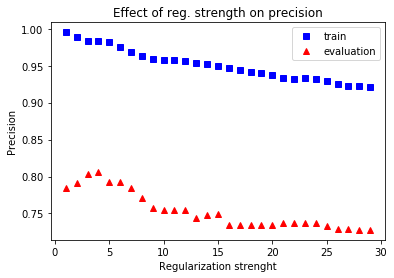

In [70]:
# precision
plt.plot(range(1, len(values)+1), pr_tr_scores, "bs", label = 'train')
plt.plot(range(1, len(values)+1), pr_eva_scores, "r^", label = 'evaluation')
plt.xlabel("Regularization strenght")
plt.ylabel('Precision')
plt.legend()
plt.title("Effect of reg. strength on precision")
plt.show()

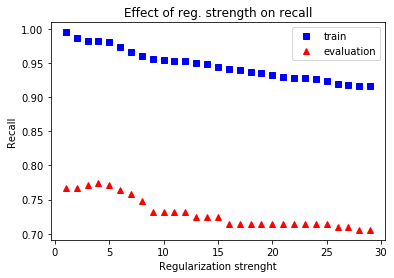

In [71]:
# recall
plt.plot(range(1, len(values)+1), re_tr_scores, "bs", label = 'train')
plt.plot(range(1, len(values)+1), re_eva_scores, "r^", label = 'evaluation')
plt.xlabel("Regularization strenght")
plt.ylabel('Recall')
plt.legend()
plt.title("Effect of reg. strength on recall")
plt.show()

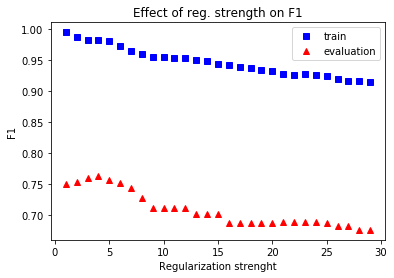

In [72]:
# f1
plt.plot(range(1, len(values)+1), f1_tr_scores, "bs", label = 'train')
plt.plot(range(1, len(values)+1), f1_eva_scores, "r^", label = 'evaluation')
plt.xlabel("Regularization strenght")
plt.ylabel('F1')
plt.legend()
plt.title("Effect of reg. strength on F1")
plt.show()

Is this right?